# Experiments for MNIST Dataset

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [2]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('device', device)
else:
    device = torch.device("cpu")
    print('device', device)

device cuda:0


In [5]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best guarantee of interpretable task decompositions
from moe_models.moe_expectation_model import moe_expectation_model
from helper.moe_models import cross_entropy_loss

device cuda:0
device cuda:0


In [6]:
import time
my_array = np.concatenate((np.arange(10**6), np.asarray([4])))
print(my_array)
start = time.time()
print(sum(4>=my_array))
now = time.time()
print(now-start)

count = 0
start = time.time()
for i in range(my_array.size):
    if 4>= my_array[i]:
#         count = count + 1
        count += 1
print(count)
print(time.time()-start)
    

[     0      1      2 ... 999998 999999      4]
6
1.336545467376709
6
0.23822689056396484


### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. 

## Load MNIST dataset

In [7]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures/test'
model_path = '../models/test'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [8]:
import torchvision.transforms as transforms

# transforms: Convert PIL image to tensors and normalize
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [9]:
# Set train and test size
trainsize = 2048
testsize = 2000
valsize = 10048

In [10]:
total_experts = 5

In [11]:
# Load and split data as train and test
trainset = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=transform)

batch_size = 64
# dataloaders
trainloaders = []
for i in range(total_experts):
    dataset = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(i*trainsize,(i*trainsize)+trainsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)
    trainloaders.append(dataset)
    all_labels = []
    for inputs, labels in dataset:
        all_labels.append(labels)
    all_labels = torch.stack(all_labels)
i+=1
valloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(i*trainsize,(i*trainsize)+valsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(0, valsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, range(0,testsize)),
                                         batch_size=testsize,
                                         shuffle=False)
num_classes = 10

image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))
print(len(trainloaders))

Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000
5


## Define expert and gate networks

In [12]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, masks, num_classes, output):
        super(expert_layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)
        self.fc1 = nn.Linear(in_features=1*12*12, out_features=5) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=5, out_features=10) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=10, out_features=num_classes)
        
        self.num_classes = num_classes
        self.masks = masks
        self.output = output
        
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*12*12)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
        
        if not self.masks is None:
            mask = torch.zeros(t.shape[0],self.num_classes)
            for m, i in zip(self.masks, range(self.output)):
                mask[:,m] = t[:,i] 
            return mask
        
        return t

In [13]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts, num_classes):
        super(gate_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)

        self.fc1 = nn.Linear(in_features=1*12*12, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=num_experts)
        self.num_experts = num_experts
        self.num_classes = num_classes
        self.count = 0

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*12*12)
        if not y is None:
            t = torch.cat((t, torch.flatten(y, start_dim=1)), dim=1)
            self.fc1 = nn.Linear(in_features=1*12*12+(self.num_experts* self.num_classes), out_features=15)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t/T, dim=1)
        return t


In [14]:
# create a set of experts
def experts(num_experts, masks, total_num_classes, num_classes, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(masks[i], total_num_classes, num_classes[i]))
    return nn.ModuleList(models)

In [15]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class single_model(nn.Module):
    def __init__(self, masks=None, num_classes=10, output=10):
        super(single_model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)
        self.fc1 = nn.Linear(in_features=1*12*12, out_features=5) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=5, out_features=10) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=10, out_features=num_classes)
        
        self.num_classes = num_classes
        self.masks = masks
        self.output = output
        
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*12*12)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
        
        if not self.masks is None:
            mask = torch.zeros(t.shape[0],self.num_classes)
            for m, i in zip(self.masks, range(self.output)):
                mask[:,m] = t[:,i] 
            return mask
        
        return t

## Initialize configurations and helper functions

In [16]:
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

In [17]:
# gate covariant shift regularization flag 
w_importance = 0.0 
w_ortho = 0.0

def generate_plot_file(dataset, specific):
    plot_file = dataset
    if w_importance > 0:
        plot_file += '_importance_'+str(w_importance)
    if w_ortho > 0:
        plot_file += '_ortho_'+str(w_ortho)
    plot_file += '_'+specific
    
    return plot_file

## Experiment 1: Train MoE expectation model with importance

In [18]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_on_validation'

In [19]:
num_epochs = 20

In [20]:
def train_experts(expert_models, trainloaders, accuracy, num_epochs):
    for i, expert in enumerate(expert_models):
        print('Training Expert ', i)
        optimizer_expert = optim.RMSprop(expert.parameters(),
                                      lr=0.001, momentum=0.9)

        loss_criterion = cross_entropy_loss()
        for epoch in range(num_epochs):
            running_loss = 0.0
            train_running_accuracy = 0.0
            num_batches = 0
            for inputs, labels in trainloaders[i]:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = expert(inputs)

                optimizer_expert.zero_grad()
                loss = loss_criterion(outputs, labels)

                loss.backward()

                optimizer_expert.step()

                running_loss += loss.item()

                outputs = expert(inputs)

                acc = accuracy(outputs, labels)
                train_running_accuracy += acc

                num_batches += 1

            print('epoch %d' % epoch,
                  'training loss %.2f' % (running_loss/num_batches),
                   ', training accuracy %.2f' % (train_running_accuracy/num_batches),
                   )

In [37]:
# Train models model_1

n_run_models = []
cv = []
accuracies = []
for e_epoch in range(1,6):
    for g_epoch in range(1,2):
        models = {
            'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
            }

        # Build model with un-trained experts
        for key, val in models.items():
            print('Model:', key, total_experts, 'Experts')
            print('Building model with un-trained experts')
            # copy and save the expert models to save the parameters

            expert_models = experts(total_experts, [None]*total_experts, num_classes, 
                                             [num_classes]*total_experts).to(device)

            gate_model = gate_layers(total_experts, num_classes).to(device)

            optimizer_gate = optim.RMSprop(gate_model.parameters(),
                                          lr=0.001, momentum=0.9)
            for epoch in range(1):
                print('\nTraining Experts')
                train_experts(expert_models, trainloaders, accuracy, e_epoch)


                moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0,
                                         experts=expert_models, gate=gate_model)


                print('\nTraining Gate')
                hist = moe_model.train_on_validation(valloader, testloader,  val['loss'], 
                                                     optimizer_gate=optimizer_gate, 
                                                     accuracy=accuracy, epochs=g_epoch)
            moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0,
                                         experts=expert_models, gate=gate_model)
            
            optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                      lr=0.001, momentum=0.9)
            print('\nTraining MoE Model')
            hist = moe_model.train(trainloader, testloader,  val['loss'], 
                                                 optimizer_moe=optimizer_moe, 
                                                 accuracy=accuracy, epochs=num_epochs)
            
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = moe_model(inputs)
                gate_outputs = moe_model.gate_outputs
                gd = torch.sum(gate_outputs, dim=0)
                cv.append((torch.std(gd)/torch.mean(gd)).item())
                accuracies.append(accuracy(outputs, labels).item())
            print(cv[-1], accuracies[-1])
            
            val['experts'][total_experts] = {'model':moe_model, 'history':hist}
        n_run_models.append(models)
        

# Save all the trained models
plot_file = generate_plot_file(model_1, str(num_classes)+'_'+str(total_experts)+'_models.pt')
print(plot_file)
torch.save(n_run_models, open(os.path.join(model_path, plot_file),'wb'))

Model: moe_expectation_model 5 Experts
Building model with un-trained experts

Training Experts
Training Expert  0
epoch 0 training loss 1.80 , training accuracy 0.35
Training Expert  1
epoch 0 training loss 1.65 , training accuracy 0.41
Training Expert  2
epoch 0 training loss 1.52 , training accuracy 0.54
Training Expert  3
epoch 0 training loss 1.89 , training accuracy 0.28
Training Expert  4
epoch 0 training loss 1.80 , training accuracy 0.36

Training Gate
epoch 0 training loss 0.96 , training accuracy 0.70 , test accuracy 0.68

Training MoE Model
epoch 0 training loss 0.74 , training accuracy 0.79 , test accuracy 0.80
epoch 1 training loss 0.51 , training accuracy 0.86 , test accuracy 0.83
epoch 2 training loss 0.42 , training accuracy 0.88 , test accuracy 0.85
epoch 3 training loss 0.39 , training accuracy 0.89 , test accuracy 0.86
epoch 4 training loss 0.36 , training accuracy 0.90 , test accuracy 0.86
epoch 5 training loss 0.35 , training accuracy 0.90 , test accuracy 0.86
epo

### Experiment 1 - Results

In [ ]:
torch.save([cv,accuracies], open('results_cv_accuracies.pt','wb'))

In [25]:
cv, accuracies = torch.load(open('results_cv_accuracies.pt','rb'))

In [42]:
cv = np.transpose(np.around(cv, decimals=3))
accuracies = np.transpose(np.around(accuracies, decimals=2))
cv

array([2.24, 2.24, 0.89, 0.74, 0.59])

In [43]:
epochs = []
for i in range(1,6):
    for j in range(1,2):
        epochs.append([[i],[j]])
epochs = np.transpose(np.hstack(epochs))
values = np.transpose(np.vstack((cv,accuracies)))
from numpy.lib import recfunctions as rfn
data = np.hstack((epochs,values))

mnist_on_validation_10_5_models.pt
mnist_on_validation_cv_accuracy_table_10_5_experts.png


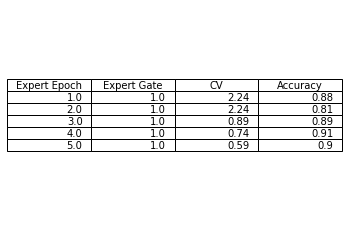

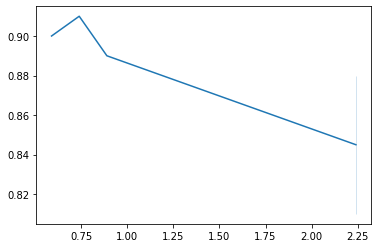


E epoch: 1.0 G epoch: 1.0

Confusion matrix of predictions of the MNIST test data by MoE expectation model


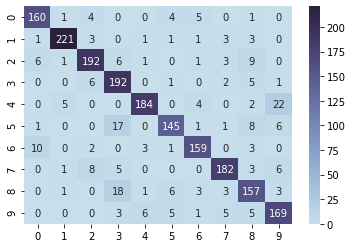


Experts used by the gate for classification of each digit


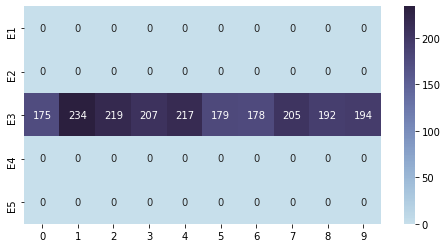


E epoch: 2.0 G epoch: 1.0

Confusion matrix of predictions of the MNIST test data by MoE expectation model


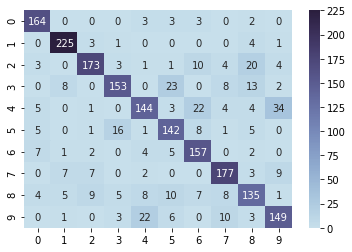


Experts used by the gate for classification of each digit


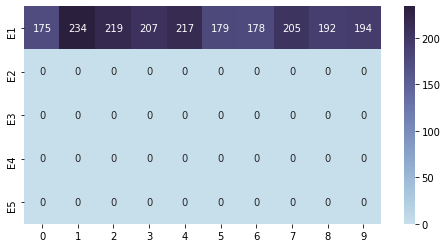


E epoch: 3.0 G epoch: 1.0

Confusion matrix of predictions of the MNIST test data by MoE expectation model


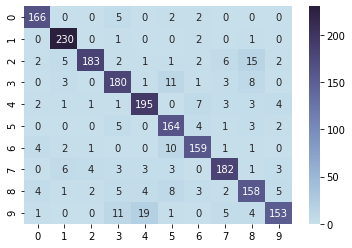


Experts used by the gate for classification of each digit


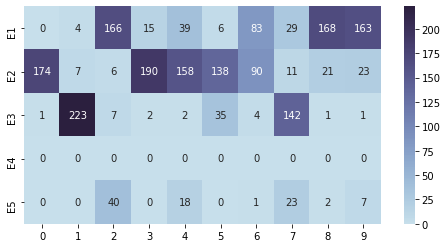


E epoch: 4.0 G epoch: 1.0

Confusion matrix of predictions of the MNIST test data by MoE expectation model


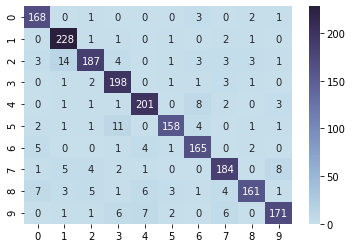


Experts used by the gate for classification of each digit


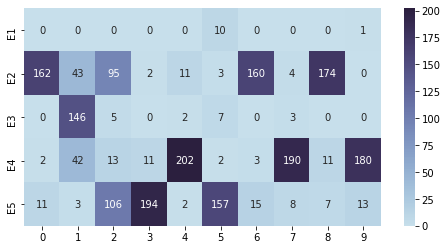


E epoch: 5.0 G epoch: 1.0

Confusion matrix of predictions of the MNIST test data by MoE expectation model


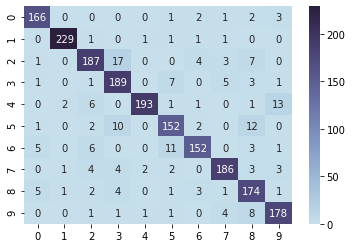


Experts used by the gate for classification of each digit


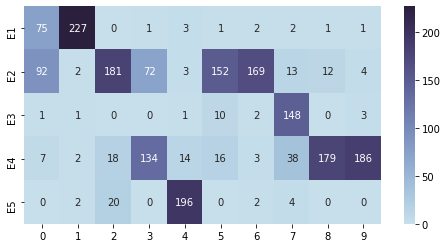

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

m = model_1
total_experts = 5
plot_file = generate_plot_file(m, str(num_classes)+'_'+str(total_experts)+'_models.pt')
models_list = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
print(plot_file)

columns = ('Expert Epoch', 'Expert Gate', 'CV', 'Accuracy')
# Add a table at the bottom of the axes
plt.box(on=None)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
the_table = plt.table(cellText=data,
                      colLabels=columns,
                     loc='center')
image_file = generate_plot_file(m, 'cv_accuracy_table_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
print(image_file)
plt.savefig(os.path.join(fig_path, image_file))
plt.show()

fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
sns.lineplot(x=cv,y=accuracies, ax=ax)
plt.show()
                      
for i, models in enumerate(models_list):
    # Plotting for the model of the first run
    print('\nE epoch:', data[i,0], 'G epoch:',data[i,1])
    for e_key, e_val in models.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        for images, labels in testloader:
            fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
            images, labels = images.to(device), labels.to(device)
            moe_model = e_val['experts'][total_experts]['model']

            # predict the classes for test data
            pred = moe_model(images)
            pred_labels = torch.argmax(pred, dim=1)

            expert_outputs = moe_model.expert_outputs
            gate_outputs = moe_model.gate_outputs

            # plot the confusion matrix
            print('\nConfusion matrix of predictions of the MNIST test data by MoE expectation model')
            sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1, cmap=cmap, fmt='d')
            image_file = generate_plot_file(m, 'conf_mat_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
            fig1.savefig(os.path.join(fig_path, image_file))
            plt.show()

            fig2,ax2 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

            # get the experts selected by the gate for each sample
            pred_gate_labels = torch.argmax(gate_outputs, dim=1)

            # plot the expert selection table
            print('\nExperts used by the gate for classification of each digit')
            class_expert_table = np.asarray([[0] * num_classes]*total_experts)
            for label, expert in zip(labels, pred_gate_labels):
                class_expert_table[expert,label] += 1
            sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d', ax=ax2)

            image_file = generate_plot_file(m, 'class_expert_table_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
            fig2.savefig(os.path.join(fig_path, image_file))
            plt.show()

### Experiment 2 - Training with single model

In [19]:
num_epochs = 20

In [20]:
model_2 = 'single_model'

In [21]:
num_classes = 10

In [22]:
sm = single_model().to(device)
optimizer = optim.RMSprop(sm.parameters(),
                              lr=0.001, momentum=0.9)

loss_criterion = cross_entropy_loss()
for epoch in range(num_epochs):
    running_loss = 0.0
    train_running_accuracy = 0.0
    num_batches = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = sm(inputs)

        optimizer.zero_grad()
        loss = loss_criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        outputs = sm(inputs)

        acc = accuracy(outputs, labels)
        train_running_accuracy += acc

        num_batches += 1

    print('epoch %d' % epoch,
          'training loss %.2f' % (running_loss/num_batches),
           ', training accuracy %.2f' % (train_running_accuracy/num_batches),
           )

epoch 0 training loss 2.06 , training accuracy 0.20
epoch 1 training loss 1.95 , training accuracy 0.24
epoch 2 training loss 1.79 , training accuracy 0.29


KeyboardInterrupt: 

In [35]:
plot_file = generate_plot_file(model_2, str(num_classes)+'_models.pt')
print(plot_file)
torch.save(sm, open(os.path.join(model_path, plot_file),'wb'))

single_model_10_models.pt


In [23]:
plot_file = generate_plot_file(model_2, str(num_classes)+'_models.pt')
sm = torch.load(open(os.path.join(model_path, plot_file),'rb'))

In [24]:
new_trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(valsize, 3*valsize)), 
                                          batch_size=2*valsize,
                                          shuffle=True)

In [25]:
image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))
print(len(new_trainloader.dataset))

Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000
20096


In [26]:
indices = None
for inputs, labels in new_trainloader:
    inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
    outputs = sm(inputs)
    indices = torch.where((torch.argmax(outputs, dim=1)==labels)==True)[0]

In [27]:
new_trainloader_1 = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, (indices+valsize)[0:valsize]), 
                                          batch_size=batch_size,
                                          shuffle=True)
print(len(new_trainloader.dataset))

20096


In [28]:
model_3 = 'selected_data'

In [61]:
# Train models model_1, model_2 and model_3 for 10 runs
models = {
    'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
    }

# Build model with un-trained experts
for key, val in models.items():
    print('Model:', key, total_experts, 'Experts')
    # copy and save the expert models to save the parameters
    expert_models = experts(total_experts, [None]*total_experts, num_classes, 
                                 [num_classes]*total_experts).to(device)

    gate_model = gate_layers(total_experts, num_classes).to(device)

    moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0,
                             experts=expert_models, gate=gate_model)


    optimizer_moe = optim.RMSprop(moe_model.parameters(),
                              lr=0.001, momentum=0.9)
    hist = moe_model.train(new_trainloader_1, testloader,  val['loss'], optimizer_moe, 
                           w_importance=1.0,
                           accuracy=accuracy, epochs=num_epochs)
    val['experts'][total_experts] = {'model':moe_model, 'history':hist}

# Save all the trained models
plot_file = generate_plot_file(model_3, 'importance_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')
print(plot_file)
torch.save(models,open(os.path.join(model_path, plot_file),'wb'))

Model: moe_expectation_model 5 Experts
epoch 0 training loss 0.87 , training accuracy 0.77 , test accuracy 0.84
epoch 1 training loss 0.41 , training accuracy 0.91 , test accuracy 0.88
epoch 2 training loss 0.33 , training accuracy 0.93 , test accuracy 0.86
epoch 3 training loss 0.29 , training accuracy 0.94 , test accuracy 0.89
epoch 4 training loss 0.27 , training accuracy 0.95 , test accuracy 0.90
epoch 5 training loss 0.23 , training accuracy 0.96 , test accuracy 0.91
epoch 6 training loss 0.22 , training accuracy 0.96 , test accuracy 0.90
epoch 7 training loss 0.22 , training accuracy 0.97 , test accuracy 0.90
epoch 8 training loss 0.20 , training accuracy 0.97 , test accuracy 0.91
epoch 9 training loss 0.20 , training accuracy 0.97 , test accuracy 0.90
epoch 10 training loss 0.19 , training accuracy 0.98 , test accuracy 0.91
epoch 11 training loss 0.18 , training accuracy 0.98 , test accuracy 0.92
epoch 12 training loss 0.18 , training accuracy 0.98 , test accuracy 0.91
epoch 13 

In [29]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


Confusion matrix of predictions of the MNIST test data by MoE expectation model


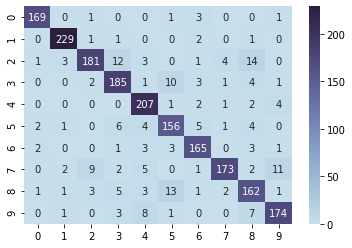


Experts used by the gate for classification of each digit


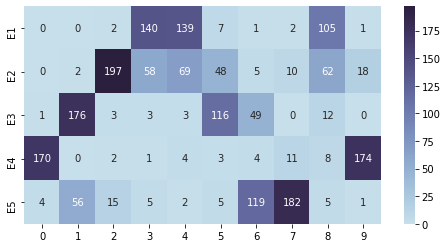

0  is misclassified as  tensor([5, 2, 6, 9, 6, 6], device='cuda:0')


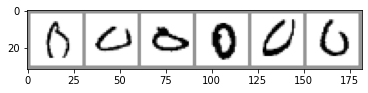

1  is misclassified as  tensor([8, 3, 6, 6, 2], device='cuda:0')


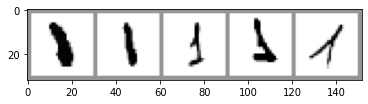

2  is misclassified as  tensor([3, 8, 3, 8, 8, 7, 8, 8, 8, 8, 1, 1, 3, 1, 8, 8, 8, 3, 3, 3, 4, 4, 3, 3,
        7, 8, 8, 3, 3, 6, 3, 8, 7, 7, 8, 3, 4, 0], device='cuda:0')


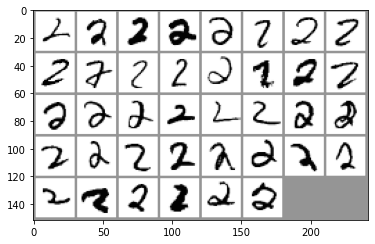

3  is misclassified as  tensor([2, 5, 5, 5, 8, 6, 5, 5, 5, 4, 8, 5, 9, 8, 5, 6, 5, 8, 7, 2, 6, 5],
       device='cuda:0')


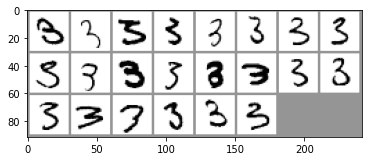

4  is misclassified as  tensor([8, 9, 9, 6, 9, 6, 7, 9, 8, 5], device='cuda:0')


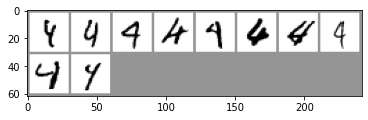

5  is misclassified as  tensor([6, 4, 6, 6, 4, 8, 3, 4, 8, 8, 3, 6, 0, 1, 7, 3, 8, 3, 3, 0, 4, 6, 3],
       device='cuda:0')


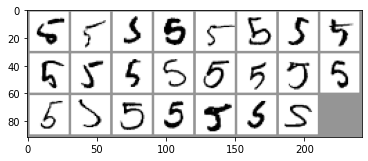

6  is misclassified as  tensor([9, 5, 0, 0, 4, 8, 5, 4, 8, 8, 5, 4, 3], device='cuda:0')


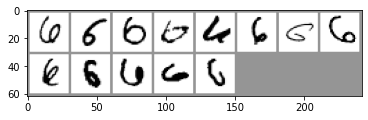

7  is misclassified as  tensor([9, 6, 1, 2, 8, 9, 9, 4, 9, 2, 9, 2, 9, 2, 2, 8, 4, 9, 3, 1, 2, 9, 2, 9,
        9, 4, 4, 3, 4, 9, 2, 2], device='cuda:0')


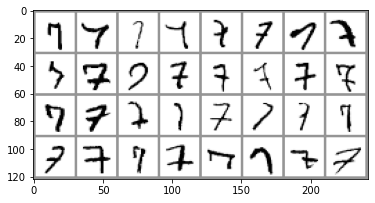

8  is misclassified as  tensor([5, 5, 7, 1, 5, 2, 3, 4, 5, 3, 5, 2, 5, 9, 3, 4, 4, 6, 5, 5, 5, 5, 5, 7,
        2, 0, 5, 5, 3, 3], device='cuda:0')


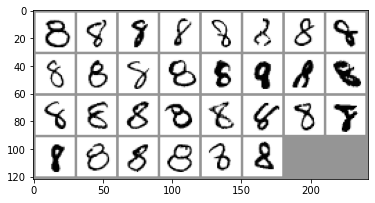

9  is misclassified as  tensor([8, 4, 1, 8, 5, 4, 4, 3, 8, 4, 8, 3, 4, 4, 4, 8, 8, 3, 4, 8],
       device='cuda:0')


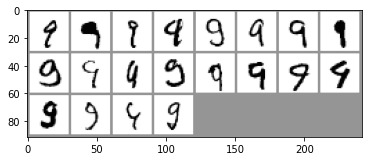

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

m = model_3
total_experts = 5
plot_file = generate_plot_file(model_3, 'importance_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')
models = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
                      
# Plotting for the model of the first run
for e_key, e_val in models.items():
    cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

    for images, labels in testloader:
        fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
        images, labels = images.to(device), labels.to(device)
        moe_model = e_val['experts'][total_experts]['model']

        # predict the classes for test data
        pred = moe_model(images)
        pred_labels = torch.argmax(pred, dim=1)
        expert_outputs = moe_model.expert_outputs
        gate_outputs = moe_model.gate_outputs

        # plot the confusion matrix
        print('\nConfusion matrix of predictions of the MNIST test data by MoE expectation model')
        sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1, cmap=cmap, fmt='d')
        image_file = generate_plot_file(m, 'conf_mat_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        fig1.savefig(os.path.join(fig_path, image_file))
        plt.show()

        fig2,ax2 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

        # get the experts selected by the gate for each sample
        pred_gate_labels = torch.argmax(gate_outputs, dim=1)

        # plot the expert selection table
        print('\nExperts used by the gate for classification of each digit')
        class_expert_table = np.asarray([[0] * num_classes]*total_experts)
        for label, expert in zip(labels, pred_gate_labels):
            class_expert_table[expert,label] += 1
        sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d', ax=ax2)

        image_file = generate_plot_file(m, 'class_expert_table_run_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        fig2.savefig(os.path.join(fig_path, image_file))
        plt.show()
        
        misclassified = torch.where((pred_labels == labels)==False)[0]
        for i in range(num_classes):
            indices = labels[misclassified]==i
            print(i,' is misclassified as ', pred_labels[misclassified][indices])
            images_orig = images[misclassified][indices]
            img_grid = torchvision.utils.make_grid(images_orig)
            # show images
            imshow(img_grid, one_channel=True)
